# 統計学をpythonで実践

## サンプルデータの準備

In [29]:
import seaborn as sns
import numpy as np

In [8]:
# seabornのサンプルデータの準備。https://github.com/mwaskom/seaborn-data
# githubのtips.csvをロード
# あるレストランで支払われたチップに関するデータ
df = sns.load_dataset('tips')

# 支払額とチップの割合のカラムを追加
df['tip_rate'] = df['tip'] / df['total_bill']
df

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204


## 分布の描画

In [12]:
# seabornのバージョン確認。
sns.__version__

'0.11.1'

上記のバージョンだとdistplotではなくdisplotが推奨

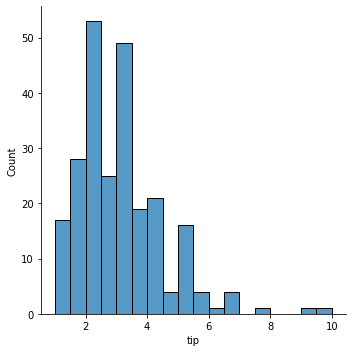

In [14]:
# ヒストグラムの描画
sns.displot(df['tip'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


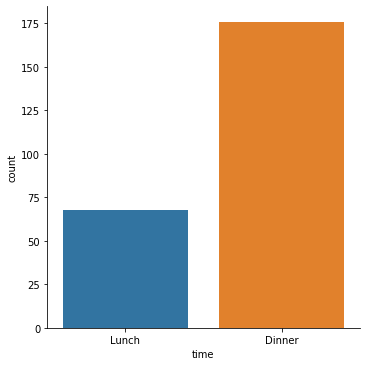

In [15]:
# 棒グラフの描画
sns.catplot('time', data=df, kind='count')

## 平均値

In [17]:
np.mean([1, 2, 3])

2.0

In [20]:
# Seriesを渡すことも可能
np.mean(df['tip'])

2.9982786885245902

In [21]:
np.mean(df['tip_rate']) 

0.16080258172250478

In [23]:
df['tip_rate'].mean()

0.16080258172250478

In [24]:
# 性別ごとに平均値を見る
df.groupby("sex").mean()

,total_bill,tip,size,tip_rate
sex,,,,
Male,20.744076,3.089618,2.630573,0.157651
Female,18.056897,2.833448,2.459770,0.166491


<AxesSubplot:xlabel='sex', ylabel='tip_rate'>

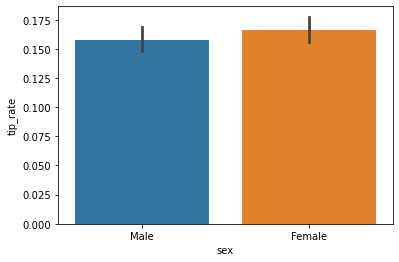

In [26]:
# カテゴリプロット
sns.barplot(x='sex', y='tip_rate', data=df)

何も指定しなくても平均が表示される。これはestimatorという引数のデフォルトがmean関数であるため。  
また、黒の縦棒はエラーバーを示す。消す場合はci=Noneを指定する。

<AxesSubplot:xlabel='sex'>

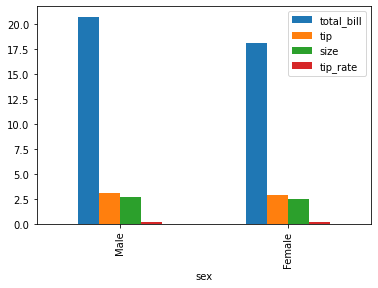

In [28]:
# Seriesから棒グラフを書く
df.groupby("sex").mean().plot(kind='bar')